##### CONSOLIDACIÓN DE LOS DATOS DISPONIBLES

In [1]:
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Ruta del directorio que contiene los archivos de Excel
directorio = os.getcwd() + "/Datos"

# Obtener la lista de archivos en el directorio
archivos_excel = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.csv')]

# Lista para almacenar los DataFrames de cada archivo
dataframes = []

# Iterar sobre los archivos de Excel en el directorio
for archivo in archivos_excel:
    ruta_archivo = os.path.join(directorio, archivo)
    df = pd.read_csv(ruta_archivo)
    
    # Agregar la columna Cliente_ID utilizando expresión regular para extraer el número
    Cliente_ID = re.search(r'\d+', archivo).group()
    df['Cliente_ID'] = Cliente_ID
    df['Cliente_ID'] = df['Cliente_ID'].astype('int64')
    
    # Validar que las columnas requeridas estén presentes en el DataFrame
    if all(col in df.columns for col in ["Fecha", "Active_energy", "Reactive_energy", "Voltaje_FA", "Voltaje_FC", "Cliente_ID"]):
        dataframes.append(df)
    else:
        print(f"Faltan columnas en el archivo {archivo}")

# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)

# Leer el archivo 'sector_economico_clientes.xlsx'
df_sector = pd.read_excel('Datos/sector_economico_clientes.xlsx')

# Renombrar columnas
df_sector = df_sector.rename(columns={'Cliente:':'Cliente_ID', 'Sector Económico:':'Sector_Economico'})

# Actualizar los valores de la columna Cliente_ID
df_sector['Cliente_ID'] = pd.to_numeric(df_sector['Cliente_ID'].str.replace('Cliente ', ''))

# Fusionar los DataFrames por 'Cliente_ID' y agregar la columna 'Sector_Economico'
df_resultado = pd.merge(df_final, df_sector, on='Cliente_ID')

# Mostrar el DataFrame resultante
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces


In [2]:
df_resultado.describe()

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID
count,463425.000000,463425.000000,463425.000000,463425.000000,463425.000000
mean,1.472050,0.873086,1420.188470,1438.515836,13.682710
std,1.718780,1.158846,766.299118,746.447449,8.407285
min,-1.329018,0.000000,0.031000,0.031000,1.000000
25%,0.242788,0.112832,719.462874,748.148254,6.000000
50%,0.810771,0.380650,1625.493463,1634.696089,13.000000
75%,1.992488,1.222834,2037.276385,2040.554497,20.000000
max,14.622644,11.135141,4266.229746,4399.038932,30.000000


### Missing values

In [3]:
def generar_resumen_missing_values(dataframe):
    # Calcula la cantidad de valores faltantes por columna
    missing_values = dataframe.isnull().sum()

    # Calcula el porcentaje de valores faltantes por columna
    porcentaje_missing_values = (missing_values / len(dataframe)) * 100

    # Crea un DataFrame con la información recopilada
    resumen_missing_values = pd.DataFrame({
        'Valores Faltantes': missing_values,
        'Porcentaje Missing Values': porcentaje_missing_values
    })

    return resumen_missing_values
missing=generar_resumen_missing_values(df_resultado)
missing

,Valores Faltantes,Porcentaje Missing Values
Fecha,0,0.0
Active_energy,0,0.0
Reactive_energy,0,0.0
Voltaje_FA,0,0.0
Voltaje_FC,0,0.0
Cliente_ID,0,0.0
Sector_Economico,0,0.0


### Outliers

In [4]:
variables_numericas = df_resultado.select_dtypes(include='number')

def detectar_outliers(dataframe):
    outliers = pd.DataFrame()

    for columna in dataframe.columns:
        # Calcular el primer y tercer cuartil
        q1 = dataframe[columna].quantile(0.25)
        q3 = dataframe[columna].quantile(0.75)

        # Calcular el rango intercuartil (IQR)
        iqr = q3 - q1

        # Definir los límites para identificar outliers
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar los outliers y almacenarlos en el DataFrame de outliers
        outliers[columna] = dataframe[(dataframe[columna] < limite_inferior) | (dataframe[columna] > limite_superior)][columna]

    # Crear un DataFrame con el número de outliers y el valor máximo por columna
    resumen_outliers = pd.DataFrame({
        'Numero de Outliers': outliers.count(),
        'Valor Maximo': dataframe.max(),
        'Valor Minimo': dataframe.min()
    })

    return resumen_outliers


outliers=detectar_outliers(variables_numericas)
outliers

,Numero de Outliers,Valor Maximo,Valor Minimo
Active_energy,31703,14.622644,-1.329018
Reactive_energy,12969,11.135141,0.000000
Voltaje_FA,1,4266.229746,0.031000
Voltaje_FC,0,4399.038932,0.031000
Cliente_ID,0,30.000000,1.000000


### Correlation Matrix

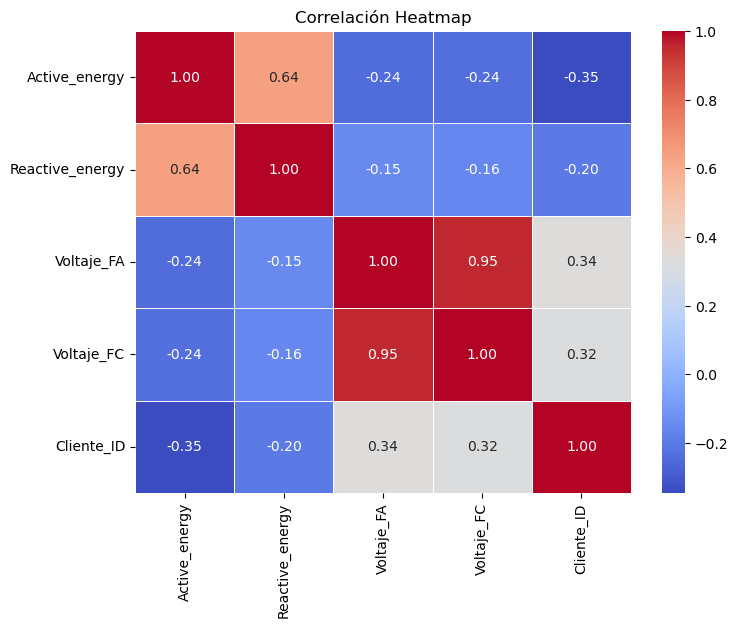

In [5]:
correlation_matrix =  df_resultado.select_dtypes(include='number').corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Correlación Heatmap')

# Mostrar el gráfico
plt.show()

### Transformación variables

#### Codificación de variable Sector_Económico

In [6]:
# Agrupar por 'Sector_Economico' 
registros_por_sector = df_resultado.groupby('Sector_Economico')['Cliente_ID'].nunique().reset_index()

registros_por_sector = registros_por_sector.rename(columns={'Cliente_ID': 'Conteo_Clientes_Unicos'})

display(registros_por_sector)


,Sector_Economico,Conteo_Clientes_Unicos
0,"Captación, tratamiento y distribución de agua",5
1,Cultivo de Hortalizas,5
2,"Cultivo de hortalizas y melones, raíces y tubé...",1
3,Cultivo de otros frutos y nueces de árboles y ...,4
4,Cultivo de Árboles Frutales y Nueces,5
5,Elaboración de cacao y chocolate y de producto...,5
6,Venta al por mayor de metales y minerales meta...,5


In [7]:
label_encoder = LabelEncoder()

# Aplicar la transformación a la columna 'Sector_Economico'
df_resultado['Sector_Economico_Num'] = label_encoder.fit_transform(df_resultado['Sector_Economico'])

# Mostrar las primeras filas del DataFrame con la nueva variable numérica
df_resultado


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5
...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4


In [8]:
df_sectores_unicos = df_resultado[['Sector_Economico', 'Sector_Economico_Num']].drop_duplicates()
df_sectores_unicos

,Sector_Economico,Sector_Economico_Num
0,Elaboración de cacao y chocolate y de producto...,5
19681,Cultivo de Árboles Frutales y Nueces,4
39362,Cultivo de otros frutos y nueces de árboles y ...,3
64777,"Cultivo de hortalizas y melones, raíces y tubé...",2
106777,"Captación, tratamiento y distribución de agua",0
223958,Cultivo de Hortalizas,1
268583,Venta al por mayor de metales y minerales meta...,6


### Adición de nueva información

#### Hora

In [9]:
# Convertir la columna 'Fecha' a tipo datetime si aún no lo está
df_resultado['Fecha'] = pd.to_datetime(df_resultado['Fecha'])

# Crear una nueva columna 'Hora' que contiene la hora de la fecha
df_resultado['Hora'] = df_resultado['Fecha'].dt.hour

# Mostrar las primeras filas del DataFrame con la nueva columna 'Hora'
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num,Hora
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5,0
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5,2
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5,3
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5,4
...,...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4,20
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4,21
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4,22
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4,23


#### Día de la semana

In [10]:
# Convertir la columna 'Fecha' a tipo datetime si aún no lo está
df_resultado['Fecha'] = pd.to_datetime(df_resultado['Fecha'])

# Crear una nueva columna 'Dia_Semana_Num' que contiene el día de la semana como número
df_resultado['Dia_Semana_Num'] = df_resultado['Fecha'].dt.dayofweek

# Mostrar las primeras filas del DataFrame con la nueva columna 'Dia_Semana_Num'
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num,Hora,Dia_Semana_Num
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5,0,4
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5,1,4
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5,2,4
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5,3,4
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5,4,4
...,...,...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4,20,4
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4,21,4
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4,22,4
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4,23,4


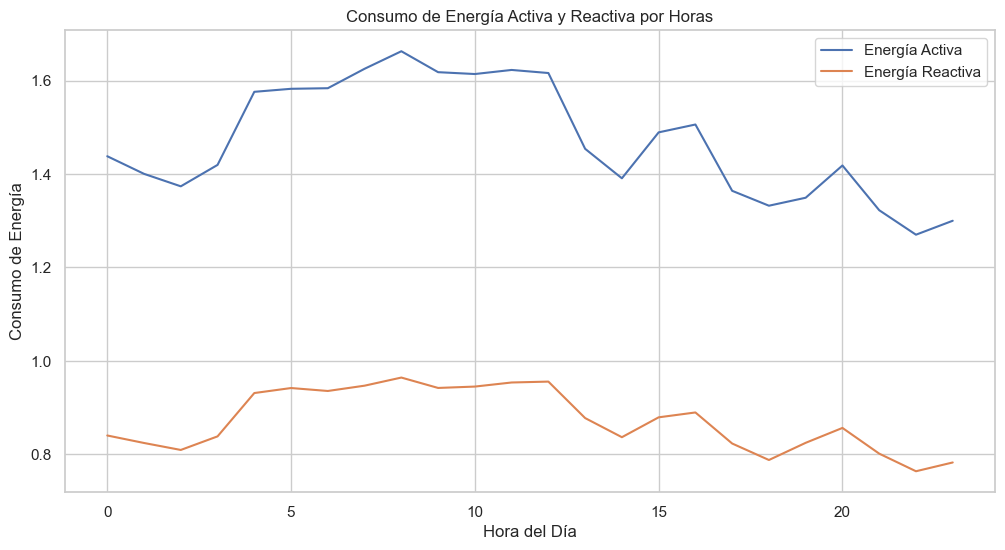

In [11]:

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura y ejes 
plt.figure(figsize=(12, 6))

# Grafica
sns.lineplot(x='Hora', y='Active_energy', data=df_resultado, label='Energía Activa', ci=None)
sns.lineplot(x='Hora', y='Reactive_energy', data=df_resultado, label='Energía Reactiva', ci=None)

plt.title('Consumo de Energía Activa y Reactiva por Horas')
plt.xlabel('Hora del Día')
plt.ylabel('Consumo de Energía')

plt.legend()

plt.show()


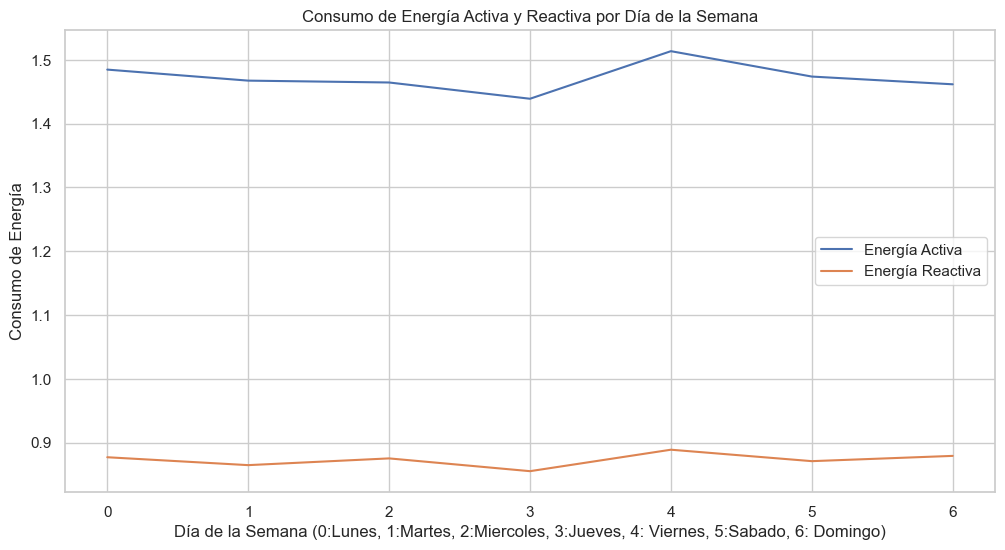

In [12]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura y ejes 
plt.figure(figsize=(12, 6))

# Grafica
sns.lineplot(x='Dia_Semana_Num', y='Active_energy', data=df_resultado, label='Energía Activa', ci=None)
sns.lineplot(x='Dia_Semana_Num', y='Reactive_energy', data=df_resultado, label='Energía Reactiva', ci=None)

plt.title('Consumo de Energía Activa y Reactiva por Día de la Semana')
plt.xlabel('Día de la Semana (0:Lunes, 1:Martes, 2:Miercoles, 3:Jueves, 4: Viernes, 5:Sabado, 6: Domingo)')
plt.ylabel('Consumo de Energía')

plt.legend()

plt.show()
